In [143]:
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier
import re, string, random
import nltk
from collections import Counter
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('data/trumptweets-1515775693.tweets.csv', low_memory='False')

In [105]:
df

,status_id,created_at,user_id,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,place_url,place_name,place_full_name,place_type,country,country_code,geo_coords,coords_coords,bbox_coords,sentiment
0,x1864367186,2009-05-20 22:29:47,x25073877,realDonaldTrump,Read a great interview with Donald Trump that ...,Twitter Web Client,112,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,x9273573134835712,2010-11-29 15:52:46,x25073877,realDonaldTrump,Congratulations to Evan Lysacek for being nomi...,Twitter Web Client,127,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,x29014512646,2010-10-28 18:53:40,x25073877,realDonaldTrump,I was on The View this morning. We talked abou...,Twitter Web Client,139,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,x7483813542232064,2010-11-24 17:20:54,x25073877,realDonaldTrump,Tomorrow night's episode of The Apprentice del...,Twitter Web Client,140,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,x5775731054,2009-11-16 21:06:10,x25073877,realDonaldTrump,Donald Trump Partners with TV1 on New Reality ...,Twitter Web Client,116,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32821,x788479634694246400,2016-10-18 20:39:28,x25073877,realDonaldTrump,RT @TeamTrump: It is time to #DrainTheSwamp in...,Twitter for iPhone,134,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
32822,x788449842854895616,2016-10-18 18:41:05,x25073877,realDonaldTrump,RT @EricTrump: Nevada: A quick reminder that t...,Twitter for iPhone,136,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
32823,x788077766063390724,2016-10-17 18:02:35,x25073877,realDonaldTrump,RT @TeamTrump: Our thoughts are with the force...,Twitter for iPhone,140,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
32824,x788048800766099456,2016-10-17 16:07:29,x25073877,realDonaldTrump,RT @TeamTrump: CORRUPTION CONFIRMED: FBI confi...,Twitter for iPhone,138,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
mentions = []




In [99]:
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

if __name__ == "__main__":

    positive_tweets = twitter_samples.strings('positive_tweets.json')
    negative_tweets = twitter_samples.strings('negative_tweets.json')
    text = twitter_samples.strings('tweets.20150430-223406.json')
    tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

    stop_words = stopwords.words('english')

    positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
    negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

    positive_cleaned_tokens_list = []
    negative_cleaned_tokens_list = []

    for tokens in positive_tweet_tokens:
        positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    for tokens in negative_tweet_tokens:
        negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    all_pos_words = get_all_words(positive_cleaned_tokens_list)

    freq_dist_pos = FreqDist(all_pos_words)
    print(freq_dist_pos.most_common(10))

    positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
    negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

    positive_dataset = [(tweet_dict, "1")
                         for tweet_dict in positive_tokens_for_model]

    negative_dataset = [(tweet_dict, "-1")
                         for tweet_dict in negative_tokens_for_model]

    dataset = positive_dataset + negative_dataset

    random.shuffle(dataset)

    train_data = dataset[:7000]
    test_data = dataset[7000:]

    classifier = NaiveBayesClassifier.train(train_data)

    print("Accuracy is:", classify.accuracy(classifier, test_data))

    print(classifier.show_most_informative_features(10))

    custom_tweet = "fuck fuck fuck"

    custom_tokens = remove_noise(word_tokenize(custom_tweet))

    print(custom_tweet, classifier.classify(dict([token, True] for token in custom_tokens)))

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]
Accuracy is: 0.9956666666666667
Most Informative Features
                      :( = True               -1 : 1      =   2065.6 : 1.0
                follower = True                1 : -1     =     36.1 : 1.0
                     sad = True               -1 : 1      =     32.4 : 1.0
                followed = True               -1 : 1      =     21.8 : 1.0
                     bam = True                1 : -1     =     19.6 : 1.0
               community = True                1 : -1     =     16.2 : 1.0
              appreciate = True                1 : -1     =     15.6 : 1.0
                    glad = True                1 : -1     =     15.3 : 1.0
                   enjoy = True                1 : -1     =     12.7 : 1.0
                 welcome = True                1 : -1     =     12.0 : 1.0
None
fuck fuck fuck -1


In [30]:
custom_tweet = "@TeamTrump is really #great"

custom_tokens = remove_noise(word_tokenize(custom_tweet))
print(custom_tokens)

print(custom_tweet, classifier.classify(dict([token, True] for token in custom_tokens)))

['teamtrump', 'be', 'really', 'great']
@TeamTrump is really #great 0


In [100]:
sentiments = df['text'].apply(lambda x: classifier.classify(dict([token, True] for token in remove_noise(word_tokenize(x)))))

In [101]:
df['sentiment'] = sentiments

In [54]:
for i in df[df['sentiment'] == '1']['text']:
    print(i)

Tomorrow night's episode of The Apprentice delivers excitement at QVC along with appearances by Isaac Mizrahi and Cathie Black. 10 pm on NBC
Watch the Miss Universe competition LIVE from the Bahamas - Sunday, 8/23 @ 9pm (ET) on NBC: http://tinyurl.com/mrzad9
Tonight's episode of The Apprentice is one you won't want to miss! Be sure to tune in--10 p.m. on NBC.
Hear Donald Trump discuss big gov spending, banks, & taxes on Your World w/Neil Cavuto: http://tinyurl.com/yhnzd7p
Tonight's episode of The Apprentice is one of the best ever--we're down to the final 3, and it's high excitement all the way. 10 pm on NBC.
“Expand your life every day.” –Donald J. Trump http://tinyurl.com/pqpfvm
"Your higher self is in direct opposition to your comfort zone." --Donald J. Trump http://tinyurl.com/pqpfvm
Reminder: The Miss Universe competition will be LIVE from the Bahamas - Tonight @ 9pm (EST) on NBC: http://tinyurl.com/mrzad9
"Think. That’s the first step. Use all your power to utilize and develop th

.@VattenfallGroup has topped Carbon Data’s rankings of the most carbon-intensive companies in the EU’s emissions trading scheme.
Lightweight @DannyZuker is too stupid to see that China (and others) is destroying the U.S. economically and our leaders are helpless! SAD.
Just tried watching Modern Family - written by a moron, really boring. Writer has the mind of a very dumb and backward child. Sorry Danny!
.@DonaldJTrumpJr and I on the 18th hole at Trump International Golf Links Scotland- http://t.co/cigLKiMoMV
"@Jdawgnuts: @realDonaldTrump if you really thought you could have won, you would have ran."  Very bad grammar (run).
Congrats to @BarbaraJWalters on winning  the @MadeinNY Mayor's Award for Lifetime Achievement! I love Barbara!
.@DannyZuker Danny—Let your bosses on Modern Family lend you the money to play the game.  Show courage!
"@GSGOV: @Lord_Sugar sad it has come to this. Clown on TV and selling nail clippers online. Ask @realDonaldTrump for a job?"
I've been warning about Chi

"@bxrocboy: @Espngreeny @realDonaldTrump was right. The NFL is ruining the game with all of the penalties. As a fan, I'm losing interest."
My interview on 9/13/01 with a German reporter after visiting Ground Zero https://t.co/uJC4G64xyN
"@Kstork48G: @realDonaldTrump I would love for you to run. What would be your plan on stopping ISIS?? Military mom here. Love you"
"@StClou: Have to agree with Mr. T, what will ruin NFL is not the off-field idiocy, but the on field idiocy of penalizing every hard tackle"
I have nothing to do with Atlantic City-sold years ago (great timing). For losers and haters, I NEVER went bankrupt. Plus $10 billion, sorry
"@SouthernRambler: @realDonaldTrump @espn you were right on! Agreed with product on field is horrible"
"@BenTrolling: @realDonaldTrump @EastonWestwood Donald Trump has more know how, grit, and integrity than George W. Bush." Very true!
"@mkristin73: @realDonaldTrump I honestly don't doubt it. We need a real leader in there."
"@NewMexicoRoni @realDo

#MakeAmericaGreatAgain #Trump2016 http://t.co/O5v9oX3pyd
.@HighSock_Sunday #asktrump http://t.co/qVakUzXZAb
.@dixierhilton #asktrump http://t.co/dbK8jckT5s
This is the first time in my life that I have caused controversy by NOT saying something.
Carly Fiorina did such a horrible job at Lucent and HP, virtually destroying both companies, that she never got another CEO job offer! Pres.
"@alivelutheran: @TODAYshow touts CNN polls instead of their own!! Of course, the NBC one shows him much higher. Trump corrects them!
I will be interviewed tonight at 7pm ET by @greta #OnTheRecord
Jeb has been confused for forty years- https://t.co/MoqjlnwryJ
I am having a really hard time watching @FoxNews.
.@ARealSuperMan #asktrump http://t.co/x2j6yiaBzU
.@_Just_Mads_ #asktrump http://t.co/zElKKmMjTU
"@TheMindWave:  @FoxNews Im not sure why u r giving them this much importance, they had wanted to take u down in debate and they failed!!"
The @TODAYshow refused to use their just in poll numbers where I hav

The Establishment and special interests are absolutely killing our country.  We must put #AmericaFirst. https://t.co/R751UfHQ0A
We are one nation. When one hurts, we all hurt. We must all work together-to lift each other up.
#StandWithLouisiana https://t.co/Ob7J2oBWhq
#WheresHillary? Sleeping!!!!!
We will repeal &amp; replace #Obamacare, which has caused soaring double-digit premium increases. It is a disaster! https://t.co/NNMyTJo6i6
#MakeAmericaSafeAgain 
https://t.co/bgBGPaKaqI
#AmericasMerkel https://t.co/QFRs4bEUC1
Another health insurer is pulling back due to 'persistent financial losses on #Obamacare plans.' Only the beginning! https://t.co/YqfaEvg8c3
"@elsolarverde: THE CORRUPT MEDIA CREATS CONTROVERSY AGAINST @realDonaldTrump TO AVOID ISSUES ABOUT HillaryClinton https://t.co/RW5UcWLfA8"
I love watching these poor, pathetic people (pundits) on television working so hard and so seriously to try and figure me out. They can't!
Tried watching low-rated @Morning_Joe this morning,  u

In [102]:
int_sentiments = df['sentiment'].apply(int)

In [103]:
df['sentiment'] = int_sentiments

In [104]:
df.to_csv('data/trump_tweets.csv', index=False)

In [81]:
mentions = []
for index, row in df.iterrows():
    tweet_mentions = [token.strip('!:.,-') for token in row['text'].split() if token[0] == '@']
    mentions.extend(tweet_mentions)

In [175]:
c = Counter(mentions)
c.most_common(20)

[('@realDonaldTrump', 7832),
 ('@BarackObama', 536),
 ('@FoxNews', 417),
 ('@foxandfriends', 408),
 ('@ApprenticeNBC', 358),
 ('@realDonaldTrump"', 267),
 ('@CNN', 244),
 ('@MittRomney', 237),
 ('@IvankaTrump', 172),
 ('@megynkelly', 141),
 ('@EricTrump', 126),
 ('@seanhannity', 122),
 ("@BarackObama's", 119),
 ('@CelebApprentice', 119),
 ('@oreillyfactor', 117),
 ('@Macys', 111),
 ('@nytimes', 108),
 ('@TrumpDoral', 101),
 ('@DonaldJTrumpJr', 88),
 ('@GOP', 88)]

In [90]:
def mean_tonality(df, word):
    word = word.lower()
    counter = 0
    sum = 0
    for index, row in df.iterrows():
        if word in row['text'].lower():
            counter += 1
            sum += row['sentiment']
    
    return sum / counter

In [181]:
print(mean_tonality(df, 'putin'))

0.10810810810810811


In [116]:
dates = {}

for index, row in df.iterrows():
    date = '-'.join(row['created_at'].split()[0].split('-')[-2::-1])
    if date not in dates:
        dates[date] = [row['sentiment']]
    else:
        dates[date].append(row['sentiment'])

In [119]:
for date in dates:
    count = len(dates[date])
    sum = 0
    for i in dates[date]:
        sum += i
    mean = sum / count
    
    dates[date] = mean

In [158]:
dates_df = pd.DataFrame.from_dict(dates, orient='index')

In [166]:
dates_df
dates_df.reset_index(inplace=True)

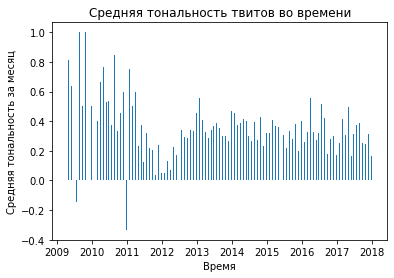

In [174]:
dates_df['index'] = pd.to_datetime(dates_df['index'], format='%m-%Y')

x = dates_df['index']
y = dates_df[0]

ax = plt.subplot(111)
ax.bar(x, y, width=10)
ax.xaxis_date()
plt.title('Средняя тональность твитов во времени')
plt.ylabel('Средняя тональность за месяц')
plt.xlabel('Время')

plt.show()

In [148]:
x = dates_df['index']
y = dates_df[0]

ax = plt.subplot(111)
ax.bar(x, y, width=10)
ax.xaxis_date()

plt.show()

ValueError: view limit minimum -10.7 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [167]:
dates_df

,index,0
0,05-2009,0.809524
1,11-2010,0.454545
2,10-2010,0.333333
3,11-2009,1.000000
4,12-2010,0.600000
...,...,...
100,05-2017,0.493151
101,04-2017,0.306667
102,03-2017,0.412587
103,02-2017,0.251701
